Created trimed video to get only reliable frames and to make process faster 

In [29]:
import cv2

def hhmmss_to_seconds(hhmmss):
    hh, mm, ss = map(int, hhmmss.split(':'))
    return hh * 3600 + mm * 60 + ss

def trim_video(input_path, output_path, start_time, end_time):
    start_seconds = hhmmss_to_seconds(start_time)
    end_seconds = hhmmss_to_seconds(end_time)

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_frame = start_seconds * fps
    end_frame = end_seconds * fps

    if end_frame > total_frames:
        end_frame = total_frames

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    current_frame = start_frame
    while cap.isOpened() and current_frame < end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        current_frame += 1

    cap.release()
    out.release()

# Example usage
input_video_path = '/mnt/hgfs/Desktop/WSC.mp4'
output_video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
start_time = '01:20:00'  # hh:mm:ss
end_time = '02:14:00'    # hh:mm:ss

# trim_video(input_video_path, output_video_path, start_time, end_time)



Compared each frame by computing similarity which is Intersection over Union  which says i.e. Area of Intersection / Area of Union 

Frame 0: Similarity 0.96
Frame 1: Similarity 0.96
Frame 2: Similarity 0.96
Frame 3: Similarity 0.96
Frame 4: Similarity 0.96
Frame 5: Similarity 0.96
Frame 6: Similarity 0.96
Frame 7: Similarity 0.96
Frame 8: Similarity 0.96
Frame 9: Similarity 0.96
Frame 10: Similarity 0.96
Frame 11: Similarity 0.96
Frame 12: Similarity 0.96
Frame 13: Similarity 0.96
Frame 14: Similarity 0.96
Frame 15: Similarity 0.96
Frame 16: Similarity 0.95
Frame 17: Similarity 0.95
Frame 18: Similarity 0.95
Frame 19: Similarity 0.95
Frame 20: Similarity 0.95
Frame 21: Similarity 0.94
Frame 22: Similarity 0.94
Frame 23: Similarity 0.94
Frame 24: Similarity 0.94
Frame 25: Similarity 0.93
Frame 26: Similarity 0.93
Frame 27: Similarity 0.93
Frame 28: Similarity 0.93
Frame 29: Similarity 0.93
Frame 30: Similarity 0.92
Frame 31: Similarity 0.92
Frame 32: Similarity 0.91
Frame 33: Similarity 0.91
Frame 34: Similarity 0.90
Frame 35: Similarity 0.90
Frame 36: Similarity 0.89
Frame 37: Similarity 0.89
Frame 38: Similarity 0

[mpeg4 @ 0xaaaaeec1fef0] header damaged


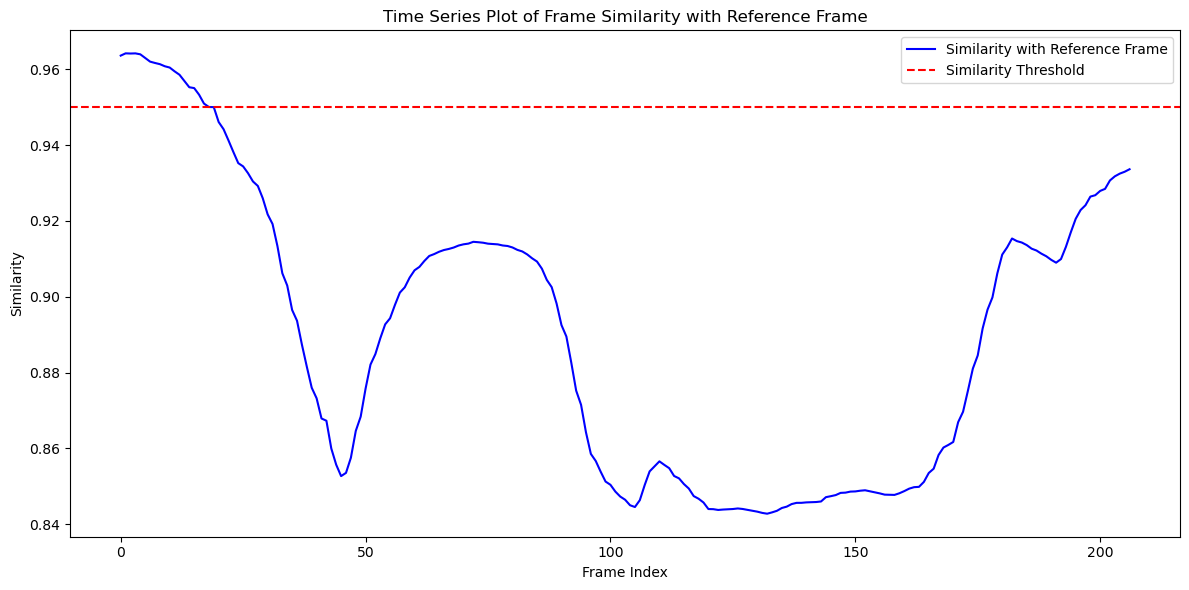

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_similarity(frame1, frame2):
    
    hsv1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
    
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    
    mask1 = cv2.inRange(hsv1, lower_green, upper_green)
    mask2 = cv2.inRange(hsv2, lower_green, upper_green)
    
    intersection = cv2.bitwise_and(mask1, mask2)
    
    similarity = np.sum(intersection) / (np.sum(mask1) + np.sum(mask2) - np.sum(intersection))
    
    return similarity

def plot_similarity_graph(video_path, ref_frame_path, threshold=0.95):
    cap = cv2.VideoCapture(video_path)
    ref_frame = cv2.imread(ref_frame_path)

    if ref_frame is None:
        print("Error: Could not load reference frame.")
        return

    frame_count = 0
    frame_indices = []
    similarities = []

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        similarity = compute_similarity(ref_frame, frame)
        similarities.append(similarity)
        frame_indices.append(frame_count)
        
        print(f"Frame {frame_count}: Similarity {similarity:.2f}")
        
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, similarities, label='Similarity with Reference Frame', color='blue')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Similarity Threshold')
    plt.title('Time Series Plot of Frame Similarity with Reference Frame')
    plt.xlabel('Frame Index')
    plt.ylabel('Similarity')
    plt.legend()
    plt.tight_layout()
    plt.show()


video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
ref_frame_path = '/mnt/hgfs/Desktop/WSC sample.png'
plot_similarity_graph(video_path, ref_frame_path)


In [30]:
import cv2
import numpy as np
import os

output_path = 'frames'
if not os.path.exists(output_path):
    os.makedirs(output_path)

def compute_similarity(frame1, frame2):
    # Convert frames to the HSV color space
    hsv1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
    
    # Define range for the color green in HSV space
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    
    # Create masks for the green color in both frames
    mask1 = cv2.inRange(hsv1, lower_green, upper_green)
    mask2 = cv2.inRange(hsv2, lower_green, upper_green)
    
    # Compute the intersection of the two masks
    intersection = cv2.bitwise_and(mask1, mask2)
    
    # Compute the similarity as the ratio of intersection to the union of the masks
    similarity = np.sum(intersection) / (np.sum(mask1) + np.sum(mask2) - np.sum(intersection))
    
    return similarity

def extract_side_view_frames(video_path, ref_frame_path, threshold=0.95, output_path='frames'):
    cap = cv2.VideoCapture(video_path)
    ref_frame = cv2.imread(ref_frame_path)

    if ref_frame is None:
        print("Error: Could not load reference frame.")
        return

    frame_count = 0

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        similarity = compute_similarity(ref_frame, frame)
        if similarity >= threshold:
            frame_path = f"{output_path}/frame_{frame_count:04d}_{similarity:.2f}.jpg"
            cv2.imwrite(frame_path, frame)
            cv2.rectangle(frame, (10, 10), (110, 50), (0, 255, 0), -1)
            cv2.putText(frame, "Saved", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
        else:
            cv2.rectangle(frame, (10, 10), (210, 50), (0, 0, 255), -1)
            cv2.putText(frame, "Not Saved", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        frame_count += 1
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"Total frames: {frame_count}")

# Usage
video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
ref_frame_path = '/mnt/hgfs/Desktop/WSC sample.png'
# extract_side_view_frames(video_path, ref_frame_path)


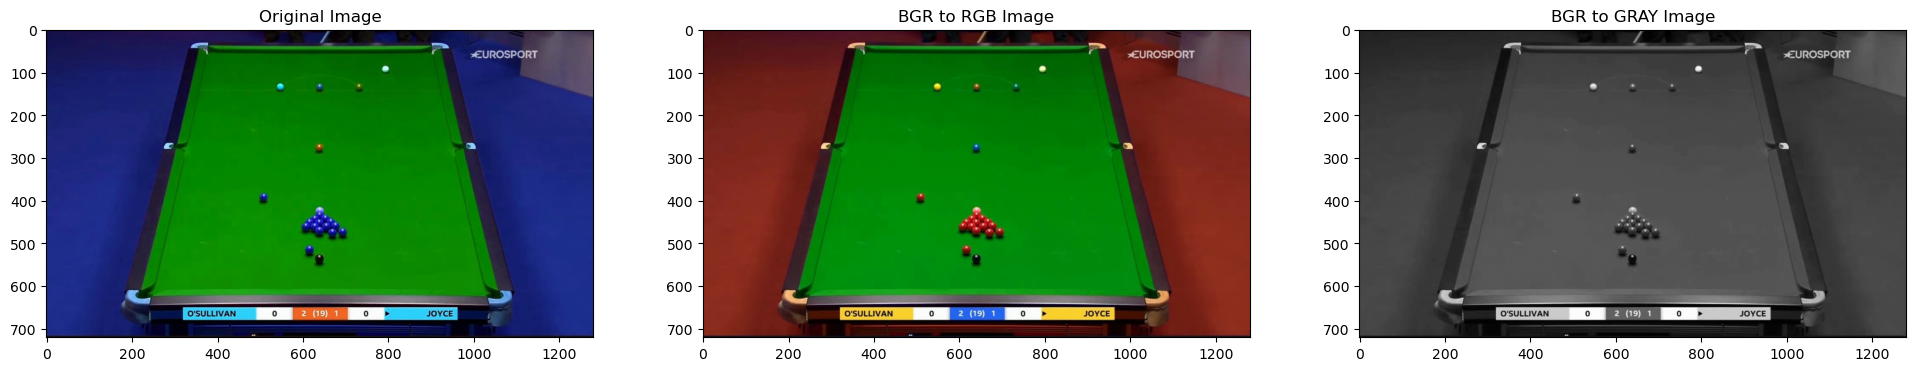

In [31]:
from matplotlib import pyplot as plt

image_path = "/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(24,24))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1,3,2)
plt.title("BGR to RGB Image")
plt.imshow(RGB_image)
plt.subplot(1,3,3)
plt.title("BGR to GRAY Image")
plt.imshow(gray_image,cmap='gray')
plt.show()

Understanding of sobel function 

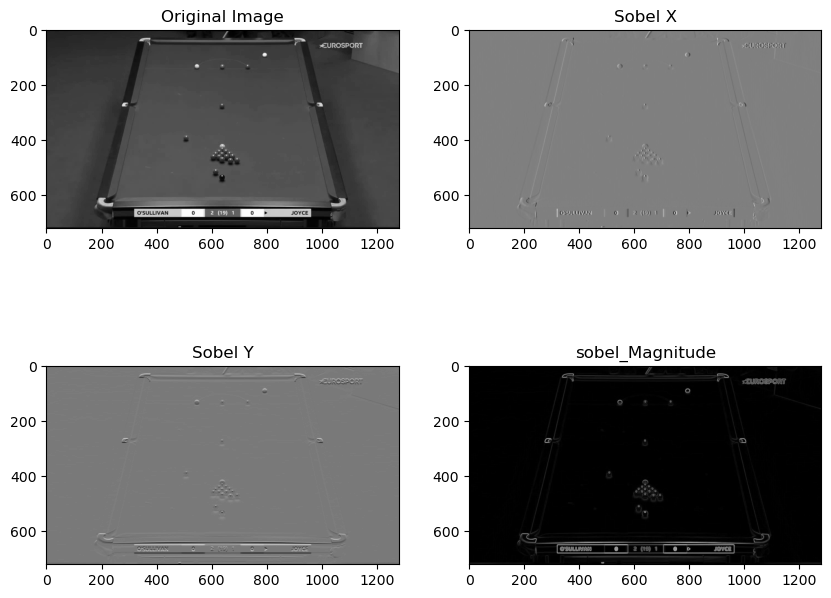

In [83]:
def PAC(img):

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    sobel_mag = np.sqrt(sobelx**2 + sobely**2) 
    sobel_mag = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX)

    return sobel_mag,sobelx,sobely,img

sobel_mag,sobelx,sobely,img = PAC(gray_image)
sobel_mag,sobelx,sobely,img

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(2, 2, 2)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.subplot(2, 2, 3)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.subplot(2, 2, 4)
plt.imshow(sobel_mag, cmap='gray')
plt.title('sobel_Magnitude')
plt.show()

In [84]:
height, width = sobel_mag.shape
print(f"height:{height},width:{width}")

height:720,width:1280


Using the hough transform we have defined the corners using sobel gradiants 


Detected lines (rho, theta):
rho: -886, theta in degrees: 167.0
rho: 37, theta in degrees: 90.0
rho: 40, theta in degrees: 90.0
rho: 356, theta in degrees: 13.0
rho: 361, theta in degrees: 14.0
rho: 606, theta in degrees: 90.0
rho: 620, theta in degrees: 90.0
rho: 637, theta in degrees: 90.0
rho: 643, theta in degrees: 90.0
rho: 648, theta in degrees: 90.0
rho: 651, theta in degrees: 90.0
rho: 652, theta in degrees: 90.0
rho: 677, theta in degrees: 90.0
rho: 681, theta in degrees: 90.0
rho: 690, theta in degrees: 90.0
rho: 715, theta in degrees: 90.0
Detected intersections (corners):
x: 917, y: 36
x: 918, y: 39
x: 637, y: -1178
x: 651, y: -1118
x: 1049, y: 606
x: 1052, y: 620
x: 1056, y: 637
x: 1057, y: 643
x: 1058, y: 648
x: 1059, y: 651
x: 1059, y: 652
x: 1065, y: 677
x: 1066, y: 681
x: 1068, y: 690
x: 1074, y: 715
x: 356, y: 36
x: 362, y: 36
x: 356, y: 39
x: 362, y: 39
x: 281, y: 362
x: 225, y: 606
x: 222, y: 620
x: 218, y: 637
x: 216, y: 643
x: 215, y: 647
x: 215, y: 651
x: 214, y:

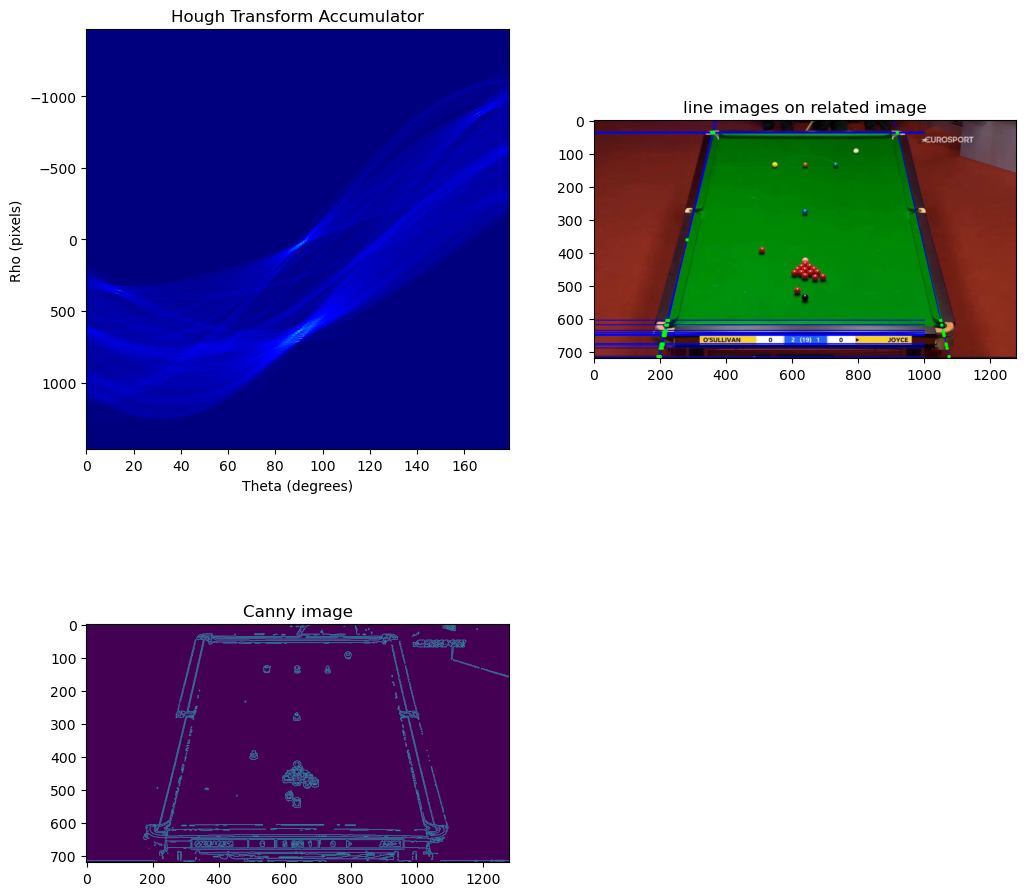

In [160]:
def hough_transform(edges, rho_res=1, theta_res=np.pi/180, threshold=280):
    height, width = edges.shape
    max_dist = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(-max_dist, max_dist, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_points = np.argwhere(edges)
    
    for y, x in edge_points:
        for theta_idx in range(len(thetas)):
            theta = thetas[theta_idx]
            rho = int(x * np.cos(theta) + y * np.sin(theta) + max_dist)
            accumulator[rho, theta_idx] += 1

    
    lines = []
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] >= threshold:
                rho = rhos[rho_idx]
                theta = thetas[theta_idx]
                lines.append((rho, theta))

    return lines,accumulator,rhos,thetas

def draw_lines(image, lines):
    line_img = np.copy(image)
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return line_img

def compute_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i]
            rho2, theta2 = lines[j]
            a1, b1 = np.cos(theta1), np.sin(theta1)
            a2, b2 = np.cos(theta2), np.sin(theta2)
            determinant = a1 * b2 - a2 * b1
            if determinant != 0:
                x = (b2 * rho1 - b1 * rho2) / determinant
                y = (a1 * rho2 - a2 * rho1) / determinant
                intersections.append((int(x), int(y)))
    return intersections

# Load and process the image
image = cv2.imread('/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobelx**2 + sobely**2)
sobel_mag = cv2.convertScaleAbs(sobel_mag)

_, threshold = cv2.threshold(sobel_mag, 50, 255, cv2.THRESH_BINARY)
threshold = np.uint8(threshold)
edges = cv2.Canny(threshold, 50, 150, apertureSize=3)

lines,accumulator,rhos,thetas = hough_transform(edges)
intersections = compute_intersections(lines)

line_img = draw_lines(image, lines)

for (x, y) in intersections:
    cv2.circle(line_img, (x, y), 5, (0, 255, 0), -1)

print("Detected lines (rho, theta):")
for line in lines:
    print(f"rho: {line[0]}, theta in degrees: {np.rad2deg(line[1])}")

print("Detected intersections (corners):")
for (x, y) in intersections:
    print(f"x: {x}, y: {y}")

plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.imshow(accumulator, cmap='jet',aspect='auto', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[-1], rhos[0]])
plt.title('Hough Transform Accumulator')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.title("line images on related image")
plt.subplot(2,2,3)
plt.imshow(edges)
plt.title('Canny image')
plt.show()


Detected spots coordinates: {'yellow': (405, 664), 'green': (638, 360), 'brown': (1054, 673), 'blue': (639, 664)}
Estimated camera matrix P:
[[-8.87782555e-14  4.22858522e-02  6.64241032e-01 -4.42944302e-02]
 [-5.13912570e-14  4.39402283e-02 -7.42283294e-01 -4.60273891e-02]
 [-8.22748222e-17  6.61750426e-05  0.00000000e+00 -6.93183571e-05]]
Intrinsic matrix K:
[[-1.00000000e+00 -1.24329081e-12 -4.36386613e-15]
 [-4.36386613e-15 -4.44089210e-15  1.00000000e+00]
 [-1.24329081e-12  1.00000000e+00  4.44089210e-15]]
Rotation matrix R:
[[ 3.00246335e+13  2.68679003e+13 -3.70260266e+16]
 [ 0.00000000e+00 -1.34719454e+00  8.94537174e+02]
 [ 0.00000000e+00  0.00000000e+00  1.51114372e+04]]
Camera center C:
[-1.32992403e+12 -1.19009833e+12  1.64004675e+15]


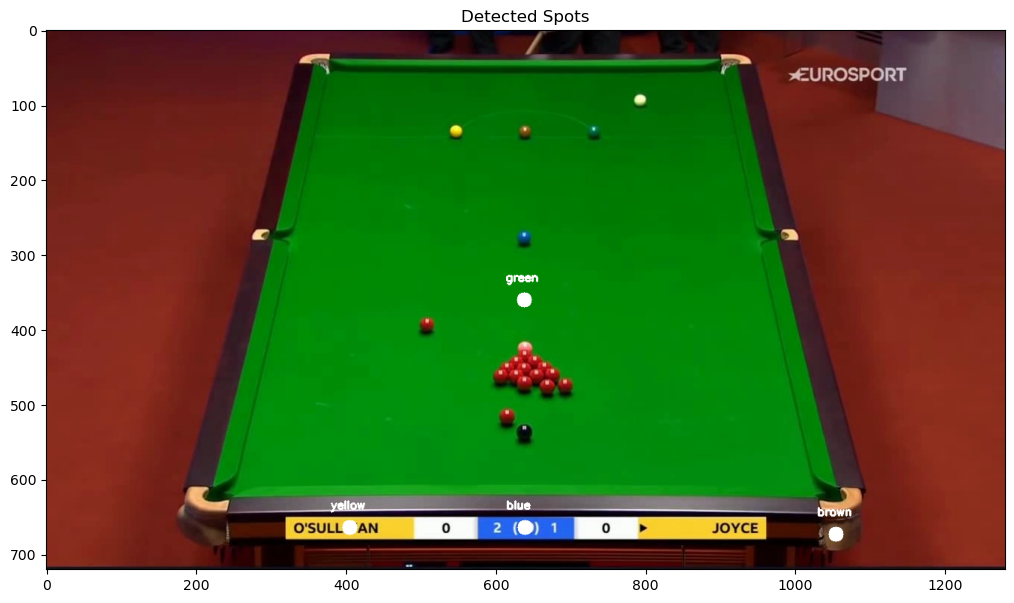

In [178]:
# yet to be decided .....

import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_spot_coordinates(image, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array(lower_hsv, dtype="uint8")
    upper = np.array(upper_hsv, dtype="uint8")
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)

    # Pre-process the image to improve contour detection
    gray_output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    gray_output = cv2.GaussianBlur(gray_output, (5, 5), 0)
    _, binary_output = cv2.threshold(gray_output, 50, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour which we assume is the spot
        largest_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            return (cX, cY)
    return None

def dlt(world_points, image_points):
    num_points = world_points.shape[0]
    A = []

    for i in range(num_points):
        X, Y, Z = world_points[i]
        u, v = image_points[i]

        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u])
        A.append([ 0,  0,  0,  0,-X, -Y, -Z, -1, v * X, v * Y, v * Z, v])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape(3, 4)

    return P

def decompose_camera_matrix(P):
    M = P[:, :3]
    p4 = P[:, 3]

    K, R = np.linalg.qr(np.linalg.inv(M))
    K = np.linalg.inv(K)

    T = np.linalg.inv(K).dot(p4)
    C = -R.T.dot(T)

    return K, R, C

def main():
    image_path = '/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg'   
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define color ranges in HSV for each color
    color_ranges = {
        'yellow': ([20, 100, 100], [30, 255, 255]),
        'green': ([35, 100, 100], [85, 255, 255]),
        'brown': ([10, 100, 20], [20, 255, 200]),  
        'blue': ([100, 150, 0], [140, 255, 255]),
        'pink': ([140, 100, 100], [170, 255, 255]),
        'black': ([0, 0, 0], [180, 255, 50])
    }

    # Find spots coordinates
    spots_coordinates = {}
    for color, (lower, upper) in color_ranges.items():
        coordinates = find_spot_coordinates(rgb_image, lower, upper)
        if coordinates:
            spots_coordinates[color] = coordinates
            cv2.circle(rgb_image, coordinates, 10, (255, 255, 255), -1)
            cv2.putText(rgb_image, color, (coordinates[0] - 25, coordinates[1] - 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    print("Detected spots coordinates:", spots_coordinates)

    # Corresponding 3D world coordinates (manual)
    world_coords = {
        'yellow': (0.292, 1.0475, 0),
        'green': (0, 1.0475, 0),
        'brown': (-0.292, 1.0475, 0),
        'blue': (0, 0, 0),
        'pink': (0, -0.89225, 0),
        'black': (0, -1.4605, 0)
    }

    # Ensure all colors are detected
    detected_colors = list(spots_coordinates.keys())
    world_coords = {color: world_coords[color] for color in detected_colors}

    # Prepare data for DLT
    image_points = np.array([spots_coordinates[color] for color in detected_colors])
    world_points = np.array([world_coords[color] for color in detected_colors])

    # Compute the camera matrix P using DLT
    P = dlt(world_points, image_points)
    print("Estimated camera matrix P:")
    print(P)

    # Decompose P to get K, R, and C
    K, R, C = decompose_camera_matrix(P)
    print("Intrinsic matrix K:")
    print(K)
    print("Rotation matrix R:")
    print(R)
    print("Camera center C:")
    print(C)

    # Visualize the detected points
    plt.figure(figsize=(15, 7))
    plt.imshow(rgb_image)
    plt.title('Detected Spots')
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import cv2

# Load the image
image_path = '/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg'
image = cv2.imread(image_path)
points = []

def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Store the coordinates
        points.append((x, y))
        # Display the coordinates on the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, str(x) + ',' + str(y), (x, y), font, 0.5, (255, 0, 0), 2)
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow('image', image)

# Display the image and set the callback function
cv2.imshow('image', image)
cv2.setMouseCallback('image', click_event)

# Wait until a key is pressed
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the points
print(points)